## Fine-Tune DNABERT6 for 3UTR knockdown prediction

In [1]:
import os
import torch
import torch.nn as nn
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from tqdm import tqdm
import RNA
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import mlflow

# RNA-FAM libraries
from multimolecule import RnaTokenizer, RnaFmModel

/Users/angelmurillo/Desktop/ML Projects/3UTR_BERT/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Import Dataset

In [2]:
df = pd.read_excel("/Users/angelmurillo/Desktop/ML Projects/3UTR_BERT/dataset_builder/Huesken_dataset_cleaned.xlsx")
df = df[['siRNA', 'mRNA', 'normalized_inhibition']]
df.head()

,siRNA,mRNA,normalized_inhibition
0,CTAATATGTTAATTGATTTAT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.344519
1,AATATGTTAATTGATTTATAC,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.286353
2,GATTTATACAATTCCTTTCAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.383296
3,CAATTCCTTTCAATTTTATCT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.271439
4,CAGACCAAAATTAAATAAGAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.389262


Feature Engineering (ViennaRNA)


In [3]:
# I need to convert the DNA sequences to RNA sequences before calculating the MFE 

def dna_to_rna(sequence):
    return sequence.replace('T', 'U')

df['siRNA_rna'] = df['siRNA'].apply(dna_to_rna)
df['mRNA_rna'] = df['mRNA'].apply(dna_to_rna)

#display first few rows with new columns as rna
df.head()

,siRNA,mRNA,normalized_inhibition,siRNA_rna,mRNA_rna
0,CTAATATGTTAATTGATTTAT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.344519,CUAAUAUGUUAAUUGAUUUAU,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...
1,AATATGTTAATTGATTTATAC,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.286353,AAUAUGUUAAUUGAUUUAUAC,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...
2,GATTTATACAATTCCTTTCAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.383296,GAUUUAUACAAUUCCUUUCAA,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...
3,CAATTCCTTTCAATTTTATCT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.271439,CAAUUCCUUUCAAUUUUAUCU,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...
4,CAGACCAAAATTAAATAAGAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.389262,CAGACCAAAAUUAAAUAAGAA,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...


In [4]:
# Function to calculate MFE
def calculate_mfe(sequence):
    """Calculate minimum free energy of RNA sequence using ViennaRNA"""
    # Calculate MFE (returns tuple of (structure, mfe))
    mfe = RNA.fold(sequence)[1]
    return mfe

# Calculate MFE for both siRNA 
df['siRNA_mfe'] = df['siRNA_rna'].apply(calculate_mfe)

# Display first few rows with new features
print("Dataset with MFE features:")
df.head(-10)


Dataset with MFE features:


,siRNA,mRNA,normalized_inhibition,siRNA_rna,mRNA_rna,siRNA_mfe
0,CTAATATGTTAATTGATTTAT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.344519,CUAAUAUGUUAAUUGAUUUAU,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0
1,AATATGTTAATTGATTTATAC,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.286353,AAUAUGUUAAUUGAUUUAUAC,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0
2,GATTTATACAATTCCTTTCAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.383296,GAUUUAUACAAUUCCUUUCAA,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0
3,CAATTCCTTTCAATTTTATCT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.271439,CAAUUCCUUUCAAUUUUAUCU,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0
4,CAGACCAAAATTAAATAAGAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.389262,CAGACCAAAAUUAAAUAAGAA,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0
...,...,...,...,...,...,...
2416,CCTTGCATCTGATTTTCAGTA,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.637584,CCUUGCAUCUGAUUUUCAGUA,GGCCUCUUGGAAGCCAGAGUAUCAAGAGCAGAGAAUCUCACUAGGA...,-1.4
2417,ATCTGATTTTCAGTAACAATC,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.403430,AUCUGAUUUUCAGUAACAAUC,GGCCUCUUGGAAGCCAGAGUAUCAAGAGCAGAGAAUCUCACUAGGA...,-1.4
2418,TCTGATTTTCAGTAACAATCA,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.556301,UCUGAUUUUCAGUAACAAUCA,GGCCUCUUGGAAGCCAGAGUAUCAAGAGCAGAGAAUCUCACUAGGA...,-1.4
2419,TGATGATGACAAAGACCGAGG,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.542878,UGAUGAUGACAAAGACCGAGG,GGCCUCUUGGAAGCCAGAGUAUCAAGAGCAGAGAAUCUCACUAGGA...,0.0


Lets observe the MFE range to examine secondary structure stability

In [5]:
# displate mfe range
print("MFE range:")
print(df['siRNA_mfe'].min(), df['siRNA_mfe'].max())

MFE range:
-14.399999618530273 0.0


Feature Engineering Cont. (Dot bracket Notation)

In [6]:
def calculate_dbn_ratio(sequence):
    """Calculate ratio of paired (brackets) to unpaired (dots) nucleotides in RNA structure
    Returns: ratio of paired nucleotides (number of brackets / sequence length)"""
    
    # Get structure in dot-bracket notation (returns tuple of (structure, mfe))
    structure = RNA.fold(sequence)[0]
    
    # Count brackets (paired nucleotides) and dots (unpaired)
    paired = structure.count('(') + structure.count(')')  # Count both opening and closing brackets
    total_length = len(structure)
    
    # Calculate ratio of paired nucleotides
    ratio = paired / (2 * total_length)  # Divide by 2 since we counted both ( and )
    
    return ratio

# Calculate DBN ratio for both siRNA and mRNA sequences
df['siRNA_dbn_ratio'] = df['siRNA_rna'].apply(calculate_dbn_ratio)


# Display first few rows with new features
print("Dataset with DBN ratio features:")
df.head(-10)

Dataset with DBN ratio features:


,siRNA,mRNA,normalized_inhibition,siRNA_rna,mRNA_rna,siRNA_mfe,siRNA_dbn_ratio
0,CTAATATGTTAATTGATTTAT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.344519,CUAAUAUGUUAAUUGAUUUAU,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0,0.000000
1,AATATGTTAATTGATTTATAC,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.286353,AAUAUGUUAAUUGAUUUAUAC,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0,0.000000
2,GATTTATACAATTCCTTTCAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.383296,GAUUUAUACAAUUCCUUUCAA,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0,0.000000
3,CAATTCCTTTCAATTTTATCT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.271439,CAAUUCCUUUCAAUUUUAUCU,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0,0.000000
4,CAGACCAAAATTAAATAAGAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.389262,CAGACCAAAAUUAAAUAAGAA,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0,0.000000
...,...,...,...,...,...,...,...
2416,CCTTGCATCTGATTTTCAGTA,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.637584,CCUUGCAUCUGAUUUUCAGUA,GGCCUCUUGGAAGCCAGAGUAUCAAGAGCAGAGAAUCUCACUAGGA...,-1.4,0.190476
2417,ATCTGATTTTCAGTAACAATC,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.403430,AUCUGAUUUUCAGUAACAAUC,GGCCUCUUGGAAGCCAGAGUAUCAAGAGCAGAGAAUCUCACUAGGA...,-1.4,0.190476
2418,TCTGATTTTCAGTAACAATCA,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.556301,UCUGAUUUUCAGUAACAAUCA,GGCCUCUUGGAAGCCAGAGUAUCAAGAGCAGAGAAUCUCACUAGGA...,-1.4,0.190476
2419,TGATGATGACAAAGACCGAGG,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.542878,UGAUGAUGACAAAGACCGAGG,GGCCUCUUGGAAGCCAGAGUAUCAAGAGCAGAGAAUCUCACUAGGA...,0.0,0.000000


Lets extract RNA-FAM features for siRNA to add additional features

In [7]:
import numpy as np

tokenizer = RnaTokenizer.from_pretrained('multimolecule/rnafm')
rnafm_model = RnaFmModel.from_pretrained('multimolecule/rnafm')

# Initializing a list to store the feature vectors
siRNA_features_list = []

# Function to extract features from each siRNA sequence
def extract_features(sequence):
    input_data = tokenizer(sequence, return_tensors='pt')
    with torch.no_grad():
        output = rnafm_model(**input_data)
    features = output.last_hidden_state.squeeze().mean(dim=0)
    return features.numpy()

# Apply the function to each siRNA and store the features in the list
for sequence in df['siRNA_rna']:
    features = extract_features(sequence)
    siRNA_features_list.append(features)

# Convert the list to a numpy array for later use
siRNA_features_array = np.array(siRNA_features_list)

# Check the dimensions of the extracted features
print(f"Feature array shape: {siRNA_features_array.shape}") #generated an array of 2431 X 640

Some weights of RnaFmModel were not initialized from the model checkpoint at multimolecule/rnafm and are newly initialized: ['rnafm.pooler.dense.bias', 'rnafm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Feature array shape: (2431, 640)


Lets observe the DBN ratio range to examine secondary structure stability

In [8]:
# displate dbn ratio range
print("DBN ratio range:")
print(df['siRNA_dbn_ratio'].min(), df['siRNA_dbn_ratio'].max())

DBN ratio range:
0.0 0.42857142857142855


Feature Engineering Cont. (G/C Content for both siRNA and mRNA)

In [9]:
def calculate_gc_content(sequence):
    """Calculate GC content of DNA sequence"""
    gc_count = sequence.count('G') + sequence.count('C')
    total_length = len(sequence)
    gc_content = gc_count / total_length
    return gc_content

# Calculate GC content for both siRNA and mRNA sequences
df['siRNA_gc_content'] = df['siRNA_rna'].apply(calculate_gc_content)
df['mRNA_gc_content'] = df['mRNA_rna'].apply(calculate_gc_content)

# Display first few rows with new features
print("Dataset with GC content features:")
df.head(-10)

Dataset with GC content features:


,siRNA,mRNA,normalized_inhibition,siRNA_rna,mRNA_rna,siRNA_mfe,siRNA_dbn_ratio,siRNA_gc_content,mRNA_gc_content
0,CTAATATGTTAATTGATTTAT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.344519,CUAAUAUGUUAAUUGAUUUAU,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0,0.000000,0.142857,0.382766
1,AATATGTTAATTGATTTATAC,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.286353,AAUAUGUUAAUUGAUUUAUAC,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0,0.000000,0.142857,0.382766
2,GATTTATACAATTCCTTTCAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.383296,GAUUUAUACAAUUCCUUUCAA,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0,0.000000,0.238095,0.382766
3,CAATTCCTTTCAATTTTATCT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.271439,CAAUUCCUUUCAAUUUUAUCU,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0,0.000000,0.238095,0.382766
4,CAGACCAAAATTAAATAAGAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.389262,CAGACCAAAAUUAAAUAAGAA,GUGCGGAUGCCGGCCGGCAGCAGCAUCAUGGCUCACGGGCCCGGCG...,0.0,0.000000,0.238095,0.382766
...,...,...,...,...,...,...,...,...,...
2416,CCTTGCATCTGATTTTCAGTA,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.637584,CCUUGCAUCUGAUUUUCAGUA,GGCCUCUUGGAAGCCAGAGUAUCAAGAGCAGAGAAUCUCACUAGGA...,-1.4,0.190476,0.380952,0.521750
2417,ATCTGATTTTCAGTAACAATC,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.403430,AUCUGAUUUUCAGUAACAAUC,GGCCUCUUGGAAGCCAGAGUAUCAAGAGCAGAGAAUCUCACUAGGA...,-1.4,0.190476,0.285714,0.521750
2418,TCTGATTTTCAGTAACAATCA,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.556301,UCUGAUUUUCAGUAACAAUCA,GGCCUCUUGGAAGCCAGAGUAUCAAGAGCAGAGAAUCUCACUAGGA...,-1.4,0.190476,0.285714,0.521750
2419,TGATGATGACAAAGACCGAGG,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.542878,UGAUGAUGACAAAGACCGAGG,GGCCUCUUGGAAGCCAGAGUAUCAAGAGCAGAGAAUCUCACUAGGA...,0.0,0.000000,0.476190,0.521750


In [10]:
#Lets observe the GC content range to examine secondary structure stability
print("GC content range:")
print(df['siRNA_gc_content'].min(), df['siRNA_gc_content'].max())
print(df['mRNA_gc_content'].min(), df['mRNA_gc_content'].max())

GC content range:
0.14285714285714285 0.9523809523809523
0.3410689170182841 0.6418636995827538


In [11]:
# lets observe all the columns 
df.columns

Index(['siRNA', 'mRNA', 'normalized_inhibition', 'siRNA_rna', 'mRNA_rna',
       'siRNA_mfe', 'siRNA_dbn_ratio', 'siRNA_gc_content', 'mRNA_gc_content'],
      dtype='object')

In [12]:
df_cleaned= df.drop(columns=['siRNA_rna', 'mRNA_rna'])
df_cleaned.head()

,siRNA,mRNA,normalized_inhibition,siRNA_mfe,siRNA_dbn_ratio,siRNA_gc_content,mRNA_gc_content
0,CTAATATGTTAATTGATTTAT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.344519,0.0,0.0,0.142857,0.382766
1,AATATGTTAATTGATTTATAC,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.286353,0.0,0.0,0.142857,0.382766
2,GATTTATACAATTCCTTTCAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.383296,0.0,0.0,0.238095,0.382766
3,CAATTCCTTTCAATTTTATCT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.271439,0.0,0.0,0.238095,0.382766
4,CAGACCAAAATTAAATAAGAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.389262,0.0,0.0,0.238095,0.382766


In [13]:
# Only normalize DBN ratio and GC content
df_cleaned['siRNA_dbn_ratio_norm'] = (df['siRNA_dbn_ratio'] - df['siRNA_dbn_ratio'].min()) / (df['siRNA_dbn_ratio'].max() - df['siRNA_dbn_ratio'].min())
df_cleaned['siRNA_gc_content_norm'] = (df['siRNA_gc_content'] - df['siRNA_gc_content'].min()) / (df['siRNA_gc_content'].max() - df['siRNA_gc_content'].min())
df_cleaned['mRNA_gc_content_norm'] = (df['mRNA_gc_content'] - df['mRNA_gc_content'].min()) / (df['mRNA_gc_content'].max() - df['mRNA_gc_content'].min())
df_cleaned.head()

,siRNA,mRNA,normalized_inhibition,siRNA_mfe,siRNA_dbn_ratio,siRNA_gc_content,mRNA_gc_content,siRNA_dbn_ratio_norm,siRNA_gc_content_norm,mRNA_gc_content_norm
0,CTAATATGTTAATTGATTTAT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.344519,0.0,0.0,0.142857,0.382766,0.0,0.000000,0.138621
1,AATATGTTAATTGATTTATAC,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.286353,0.0,0.0,0.142857,0.382766,0.0,0.000000,0.138621
2,GATTTATACAATTCCTTTCAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.383296,0.0,0.0,0.238095,0.382766,0.0,0.117647,0.138621
3,CAATTCCTTTCAATTTTATCT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.271439,0.0,0.0,0.238095,0.382766,0.0,0.117647,0.138621
4,CAGACCAAAATTAAATAAGAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.389262,0.0,0.0,0.238095,0.382766,0.0,0.117647,0.138621


Lets create final dataset

In [14]:
df_final= df_cleaned.drop(columns=['siRNA_dbn_ratio', 'siRNA_gc_content', 'mRNA_gc_content'])
df_final.head(-10)

,siRNA,mRNA,normalized_inhibition,siRNA_mfe,siRNA_dbn_ratio_norm,siRNA_gc_content_norm,mRNA_gc_content_norm
0,CTAATATGTTAATTGATTTAT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.344519,0.0,0.000000,0.000000,0.138621
1,AATATGTTAATTGATTTATAC,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.286353,0.0,0.000000,0.000000,0.138621
2,GATTTATACAATTCCTTTCAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.383296,0.0,0.000000,0.117647,0.138621
3,CAATTCCTTTCAATTTTATCT,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.271439,0.0,0.000000,0.117647,0.138621
4,CAGACCAAAATTAAATAAGAA,GTGCGGATGCCGGCCGGCAGCAGCATCATGGCTCACGGGCCCGGCG...,0.389262,0.0,0.000000,0.117647,0.138621
...,...,...,...,...,...,...,...
2416,CCTTGCATCTGATTTTCAGTA,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.637584,-1.4,0.444444,0.294118,0.600680
2417,ATCTGATTTTCAGTAACAATC,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.403430,-1.4,0.444444,0.176471,0.600680
2418,TCTGATTTTCAGTAACAATCA,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.556301,-1.4,0.444444,0.176471,0.600680
2419,TGATGATGACAAAGACCGAGG,GGCCTCTTGGAAGCCAGAGTATCAAGAGCAGAGAATCTCACTAGGA...,0.542878,0.0,0.000000,0.411765,0.600680


In [15]:
# Save the final DataFrame to Excel
df_final.to_excel("processed_Huesken_dataset.xlsx", index=False)
print("Dataset saved successfully!")

Dataset saved successfully!


Function to create k-mers

In [16]:
# Function to create k-mers
def create_kmers(seq, k=6):
    """Convert sequence to k-mers"""
    kmers = [seq[i:i+k] for i in range(len(seq) - k + 1)]
    return " ".join(kmers)

In [17]:
# Split data into train, validation, and test (70/15/15)
train_val_df, test_df = train_test_split(df_final, test_size=0.15, random_state=42)

# Second split: divide remaining data into train (70%) and validation (15%)
train_df, validation_df = train_test_split(train_val_df, test_size=0.176, random_state=42)

# Check dataset lengths 
len(train_df), len(validation_df), len(test_df)


(1702, 364, 365)

Load DNABERT6 model and tokenizer (from HuggingFace)

In [18]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNA_bert_6", trust_remote_code=True)

# Modified preprocessing function to include numerical features
def preprocess_sequences(sirna_seq, mrna_seq, numerical_features, tokenizer, max_length=512):
    # Process siRNA and mRNA 
    sirna_encoded = tokenizer(
        create_kmers(sirna_seq),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )
    mrna_encoded = tokenizer(
        create_kmers(mrna_seq),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )
    
    # Convert numerical features to tensor
    numerical_tensor = torch.tensor(numerical_features, dtype=torch.float32)
    
    return sirna_encoded, mrna_encoded, numerical_tensor

# Modified DualDNABERT model
class DualDNABERT(nn.Module):
    def __init__(self, bert_model_name="zhihan1996/DNA_bert_6", num_numerical_features=4):
        super().__init__()
        # Keep existing BERT initialization
        self.sirna_bert = AutoModel.from_pretrained(bert_model_name)
        self.mrna_bert = AutoModel.from_pretrained(bert_model_name)
        
        # Freeze layers 
        for name, param in self.sirna_bert.named_parameters():
            if 'pooler' not in name:
                param.requires_grad = False
        for name, param in self.mrna_bert.named_parameters():
            if 'pooler' not in name:
                param.requires_grad = False
        
        hidden_size = self.sirna_bert.config.hidden_size
        
        # Modified regression head to include numerical features
        self.regression_head = nn.Sequential(
            nn.Linear(hidden_size * 2 + num_numerical_features, 512),  # Modified input size
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, sirna_inputs, mrna_inputs, numerical_features):
        # Process sequences 
        sirna_outputs = self.sirna_bert(**sirna_inputs)[1]
        mrna_outputs = self.mrna_bert(**mrna_inputs)[1]
        
        # Concatenate BERT outputs with numerical features
        combined = torch.cat((sirna_outputs, mrna_outputs, numerical_features), dim=1)
        
        # Pass through regression head
        output = self.regression_head(combined)
        return output

Create a Dataset Class

In [19]:
class SiRNADataset(Dataset):
    def __init__(self, sirna_seqs, mrna_seqs, numerical_features, labels, tokenizer, max_length=512):
        self.sirna_seqs = sirna_seqs
        self.mrna_seqs = mrna_seqs
        self.numerical_features = numerical_features  # Add numerical features
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sirna_encoded, mrna_encoded, numerical_tensor = preprocess_sequences(
            self.sirna_seqs[idx],
            self.mrna_seqs[idx],
            self.numerical_features[idx],  # Pass numerical features to preprocess
            self.tokenizer,
            self.max_length
        )

        return {
            'sirna_inputs': {
                'input_ids': sirna_encoded['input_ids'].flatten(),
                'attention_mask': sirna_encoded['attention_mask'].flatten()
            },
            'mrna_inputs': {
                'input_ids': mrna_encoded['input_ids'].flatten(),
                'attention_mask': mrna_encoded['attention_mask'].flatten()
            },
            'numerical_features': numerical_tensor.flatten(),  # Add numerical features to output
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

Create Dataloaders and Initialize Model

In [20]:
# Set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")  # speed up training on Mac using gpu

# Initialize model with numerical features
model = DualDNABERT(num_numerical_features=4)  # 4 numerical features
model = model.to(device)

# Create datasets
train_dataset = SiRNADataset(
    train_df['siRNA'].values,
    train_df['mRNA'].values,
    train_df[['siRNA_mfe', 'siRNA_dbn_ratio_norm', 
              'siRNA_gc_content_norm', 'mRNA_gc_content_norm']].values,
    train_df['normalized_inhibition'].values,
    tokenizer
)

validation_dataset = SiRNADataset(
    validation_df['siRNA'].values,
    validation_df['mRNA'].values,
    validation_df[['siRNA_mfe', 'siRNA_dbn_ratio_norm', 
                   'siRNA_gc_content_norm', 'mRNA_gc_content_norm']].values,
    validation_df['normalized_inhibition'].values,
    tokenizer
)

test_dataset = SiRNADataset(
    test_df['siRNA'].values,
    test_df['mRNA'].values,
    test_df[['siRNA_mfe', 'siRNA_dbn_ratio_norm', 
             'siRNA_gc_content_norm', 'mRNA_gc_content_norm']].values,
    test_df['normalized_inhibition'].values,
    tokenizer
)

# Create dataloaders (keeping the same batch sizes and shuffle settings)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Checkout DualDNABERT Model with Freezed Layers

In [21]:
# print layers
for name, param in model.named_parameters():
   print(name, param.requires_grad)

sirna_bert.embeddings.word_embeddings.weight False
sirna_bert.embeddings.position_embeddings.weight False
sirna_bert.embeddings.token_type_embeddings.weight False
sirna_bert.embeddings.LayerNorm.weight False
sirna_bert.embeddings.LayerNorm.bias False
sirna_bert.encoder.layer.0.attention.self.query.weight False
sirna_bert.encoder.layer.0.attention.self.query.bias False
sirna_bert.encoder.layer.0.attention.self.key.weight False
sirna_bert.encoder.layer.0.attention.self.key.bias False
sirna_bert.encoder.layer.0.attention.self.value.weight False
sirna_bert.encoder.layer.0.attention.self.value.bias False
sirna_bert.encoder.layer.0.attention.output.dense.weight False
sirna_bert.encoder.layer.0.attention.output.dense.bias False
sirna_bert.encoder.layer.0.attention.output.LayerNorm.weight False
sirna_bert.encoder.layer.0.attention.output.LayerNorm.bias False
sirna_bert.encoder.layer.0.intermediate.dense.weight False
sirna_bert.encoder.layer.0.intermediate.dense.bias False
sirna_bert.encoder.la

Training the Model & Setting up Optimizer and Loss Function

In [22]:
# MLflow setup
os.environ['MLFLOW_TRACKING_URI'] = 'http://localhost:5003'
experiment_name = "siRNA-Efficiency-DNABERT-Training"
mlflow.set_experiment(experiment_name)

# Initialize optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)
loss_fn = nn.MSELoss()

# Training parameters
num_epochs = 100
best_val_loss = float('inf')
patience = 5
patience_counter = 0
checkpoint_epochs = [25, 50, 75, 100]

# Lists to store metrics for plotting
train_losses = []
val_losses = []
r2_scores = []
pcc_scores = []
learning_rates = []

# Start MLflow run
with mlflow.start_run():
    # Log model parameters
    mlflow.log_params({
        "learning_rate": 2e-5,
        "num_epochs": num_epochs,
        "patience": patience,
        "loss_function": "MSELoss",
        "optimizer": "AdamW",
        "scheduler": "ReduceLROnPlateau"
    })

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        # Training loop
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}')
        for batch in train_pbar:
            # Move batch to device and include numerical features
            sirna_inputs = {k: v.to(device) for k, v in batch['sirna_inputs'].items()}
            mrna_inputs = {k: v.to(device) for k, v in batch['mrna_inputs'].items()}
            numerical_features = batch['numerical_features'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(sirna_inputs, mrna_inputs, numerical_features)
            loss = loss_fn(outputs.squeeze(), labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            train_pbar.set_postfix({'batch_loss': loss.item()})

        # Validation
        model.eval()
        val_loss = 0
        val_predictions = []
        val_labels = []
        with torch.no_grad():
            for batch in tqdm(validation_loader, desc='Validation'):
                sirna_inputs = {k: v.to(device) for k, v in batch['sirna_inputs'].items()}
                mrna_inputs = {k: v.to(device) for k, v in batch['mrna_inputs'].items()}
                numerical_features = batch['numerical_features'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(sirna_inputs, mrna_inputs, numerical_features)
                val_loss += loss_fn(outputs.squeeze(), labels).item()
                val_predictions.extend(outputs.squeeze().cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        # Calculate metrics
        avg_train_loss = total_loss / len(train_loader)
        avg_val_loss = val_loss / len(validation_loader)
        r2 = r2_score(val_labels, val_predictions)
        pcc, _ = pearsonr(val_labels, val_predictions)
        current_lr = optimizer.param_groups[0]['lr']

        # Store metrics for plotting
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        r2_scores.append(r2)
        pcc_scores.append(pcc)
        learning_rates.append(current_lr)

        # Log metrics to MLflow
        mlflow.log_metrics({
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "r2_score": r2,
            "pcc_score": pcc,
            "learning_rate": current_lr
        }, step=epoch)

        # Learning rate scheduling
        scheduler.step(avg_val_loss)

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save model checkpoint
            checkpoint_path = 'best_model_vanilla.pt'
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'r2_score': r2,
                'pcc_score': pcc,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'r2_scores': r2_scores,
                'pcc_scores': pcc_scores,
                'learning_rates': learning_rates
            }, checkpoint_path)
            # Log the best model to MLflow
            mlflow.log_artifact(checkpoint_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered after epoch {epoch+1}')
                mlflow.log_param("stopped_epoch", epoch + 1)
                break
        
        # Save checkpoint at specific epochs
        if epoch + 1 in checkpoint_epochs:
            checkpoint_path = f'model_checkpoint_epoch_{epoch+1}.pt'
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'r2_score': r2,
                'pcc_score': pcc,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'r2_scores': r2_scores,
                'pcc_scores': pcc_scores,
                'learning_rates': learning_rates
            }, checkpoint_path)
            # Log checkpoint to MLflow
            mlflow.log_artifact(checkpoint_path)

        print(f'Epoch {epoch+1}')
        print(f'Average training loss: {avg_train_loss:.4f}')
        print(f'Average validation loss: {avg_val_loss:.4f}')
        print(f'Validation R² score: {r2:.4f}')
        print(f'Validation PCC score: {pcc:.4f}')
        print(f'Learning rate: {current_lr:.2e}')
        print('-' * 50)

    print("Training completed!")

    # Create and save plots
    plt.figure(figsize=(15, 10))

    # Plot losses
    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot R² scores
    plt.subplot(2, 2, 2)
    plt.plot(r2_scores)
    plt.title('R² Score')
    plt.xlabel('Epoch')
    plt.ylabel('R²')

    # Plot PCC scores
    plt.subplot(2, 2, 3)
    plt.plot(pcc_scores)
    plt.title('Pearson Correlation Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('PCC')

    # Plot learning rate
    plt.subplot(2, 2, 4)
    plt.plot(learning_rates)
    plt.title('Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')

    plt.tight_layout()
    
    # Save plot and log to MLflow
    plot_path = 'training_metrics.png'
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path)
    plt.close()

2025/04/01 22:42:19 INFO mlflow.tracking.fluent: Experiment with name 'siRNA-Efficiency-DNABERT-Training' does not exist. Creating a new experiment.
Validation: 100%|██████████| 23/23 [00:11<00:00,  2.05it/s]


Epoch 1
Average training loss: 0.0219
Average validation loss: 0.0193
Validation R² score: 0.1453
Validation PCC score: 0.4866
Learning rate: 2.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:11<00:00,  2.01it/s]


Epoch 2
Average training loss: 0.0201
Average validation loss: 0.0173
Validation R² score: 0.2363
Validation PCC score: 0.5149
Learning rate: 2.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:11<00:00,  2.06it/s]


Epoch 3
Average training loss: 0.0190
Average validation loss: 0.0163
Validation R² score: 0.2773
Validation PCC score: 0.5477
Learning rate: 2.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [01:39<00:00,  4.35s/it]


Epoch 4
Average training loss: 0.0183
Average validation loss: 0.0156
Validation R² score: 0.3111
Validation PCC score: 0.5673
Learning rate: 2.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:11<00:00,  2.00it/s]


Epoch 5
Average training loss: 0.0178
Average validation loss: 0.0154
Validation R² score: 0.3174
Validation PCC score: 0.5721
Learning rate: 2.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:11<00:00,  2.06it/s]


Epoch 6
Average training loss: 0.0175
Average validation loss: 0.0155
Validation R² score: 0.3120
Validation PCC score: 0.5670
Learning rate: 2.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:11<00:00,  2.01it/s]


Epoch 7
Average training loss: 0.0177
Average validation loss: 0.0160
Validation R² score: 0.2920
Validation PCC score: 0.5779
Learning rate: 2.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:11<00:00,  2.01it/s]


Epoch 8
Average training loss: 0.0171
Average validation loss: 0.0155
Validation R² score: 0.3144
Validation PCC score: 0.5821
Learning rate: 2.00e-05
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:11<00:00,  1.94it/s]


Epoch 9
Average training loss: 0.0169
Average validation loss: 0.0150
Validation R² score: 0.3363
Validation PCC score: 0.5845
Learning rate: 2.00e-06
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:11<00:00,  1.93it/s]


Epoch 10
Average training loss: 0.0175
Average validation loss: 0.0150
Validation R² score: 0.3380
Validation PCC score: 0.5859
Learning rate: 2.00e-06
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:11<00:00,  1.93it/s]


Epoch 11
Average training loss: 0.0171
Average validation loss: 0.0150
Validation R² score: 0.3372
Validation PCC score: 0.5855
Learning rate: 2.00e-06
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:11<00:00,  1.92it/s]


Epoch 12
Average training loss: 0.0170
Average validation loss: 0.0150
Validation R² score: 0.3373
Validation PCC score: 0.5854
Learning rate: 2.00e-06
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:11<00:00,  1.92it/s]


Epoch 13
Average training loss: 0.0161
Average validation loss: 0.0149
Validation R² score: 0.3381
Validation PCC score: 0.5854
Learning rate: 2.00e-06
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:12<00:00,  1.81it/s]


Epoch 14
Average training loss: 0.0169
Average validation loss: 0.0150
Validation R² score: 0.3341
Validation PCC score: 0.5839
Learning rate: 2.00e-06
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:12<00:00,  1.89it/s]


Epoch 15
Average training loss: 0.0166
Average validation loss: 0.0149
Validation R² score: 0.3384
Validation PCC score: 0.5849
Learning rate: 2.00e-06
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:12<00:00,  1.90it/s]


Epoch 16
Average training loss: 0.0169
Average validation loss: 0.0149
Validation R² score: 0.3385
Validation PCC score: 0.5849
Learning rate: 2.00e-06
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:12<00:00,  1.90it/s]


Epoch 17
Average training loss: 0.0165
Average validation loss: 0.0149
Validation R² score: 0.3384
Validation PCC score: 0.5850
Learning rate: 2.00e-06
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:12<00:00,  1.90it/s]


Epoch 18
Average training loss: 0.0166
Average validation loss: 0.0149
Validation R² score: 0.3387
Validation PCC score: 0.5845
Learning rate: 2.00e-06
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:12<00:00,  1.89it/s]


Epoch 19
Average training loss: 0.0163
Average validation loss: 0.0150
Validation R² score: 0.3361
Validation PCC score: 0.5830
Learning rate: 2.00e-06
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:12<00:00,  1.89it/s]


Epoch 20
Average training loss: 0.0165
Average validation loss: 0.0149
Validation R² score: 0.3385
Validation PCC score: 0.5837
Learning rate: 2.00e-06
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:12<00:00,  1.85it/s]


Epoch 21
Average training loss: 0.0165
Average validation loss: 0.0150
Validation R² score: 0.3352
Validation PCC score: 0.5829
Learning rate: 2.00e-06
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:12<00:00,  1.86it/s]


Epoch 22
Average training loss: 0.0167
Average validation loss: 0.0150
Validation R² score: 0.3361
Validation PCC score: 0.5829
Learning rate: 2.00e-07
--------------------------------------------------


Validation: 100%|██████████| 23/23 [00:12<00:00,  1.85it/s]


Early stopping triggered after epoch 23
Training completed!
🏃 View run secretive-wasp-813 at: http://localhost:5003/#/experiments/948377096207670107/runs/9aa09f9414e14e88b3a8c18e3bd5444f
🧪 View experiment at: http://localhost:5003/#/experiments/948377096207670107


Testing the best Model on the test set

/var/folders/n_/wlnlq2755cbcx86b9dxhkmx40000gn/T/ipykernel_297/4216932870.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model_vanilla.pt'


Test Results:
Average test loss: 0.0160
Test R² score: 0.2537
Test PCC score: 0.5061


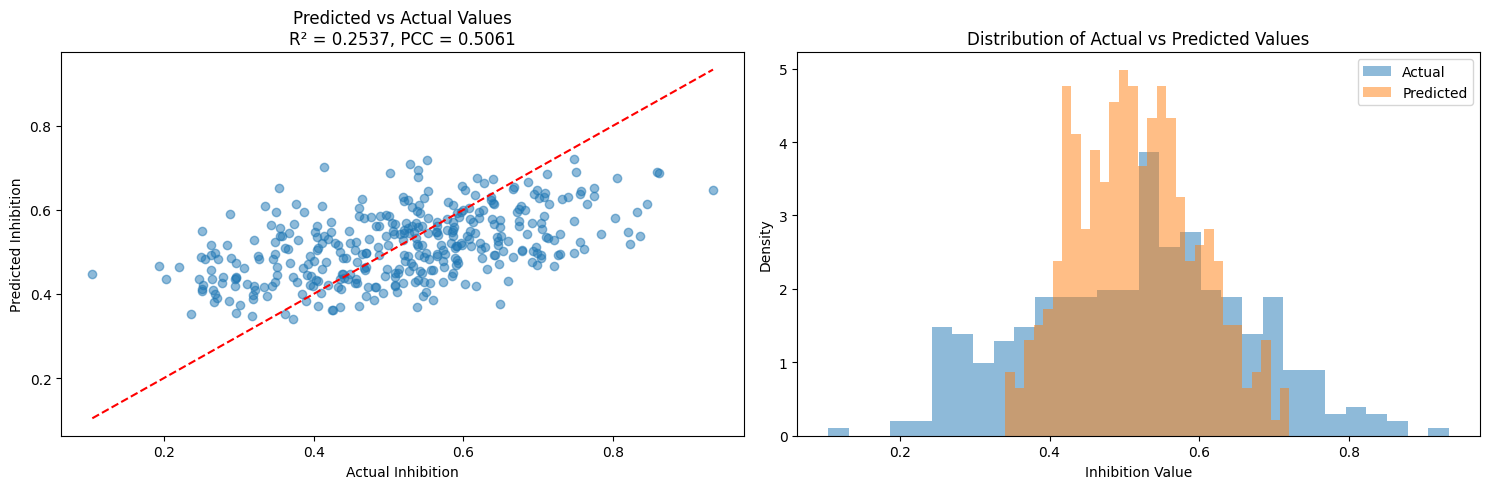

In [23]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Load best model for testing
checkpoint = torch.load('best_model_vanilla.pt')
model.load_state_dict(checkpoint['model_state_dict'])

# Test set evaluation
model.eval()
test_loss = 0
test_predictions = []
test_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Testing'):
        sirna_inputs = {k: v.to(device) for k, v in batch['sirna_inputs'].items()}
        mrna_inputs = {k: v.to(device) for k, v in batch['mrna_inputs'].items()}
        numerical_features = batch['numerical_features'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(sirna_inputs, mrna_inputs, numerical_features)
        test_loss += loss_fn(outputs.squeeze(), labels).item()
        
        # Store predictions and labels
        test_predictions.extend(outputs.squeeze().cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Calculate metrics
avg_test_loss = test_loss / len(test_loader)
test_r2 = r2_score(test_labels, test_predictions)
test_pcc, _ = pearsonr(test_labels, test_predictions)

# Print results
print(f'\nTest Results:')
print(f'Average test loss: {avg_test_loss:.4f}')
print(f'Test R² score: {test_r2:.4f}')
print(f'Test PCC score: {test_pcc:.4f}')

# Create visualization plots
plt.figure(figsize=(15, 5))

# Scatter plot of predicted vs actual values
plt.subplot(1, 2, 1)
plt.scatter(test_labels, test_predictions, alpha=0.5)
plt.plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], 'r--')  # Perfect prediction line
plt.xlabel('Actual Inhibition')
plt.ylabel('Predicted Inhibition')
plt.title(f'Predicted vs Actual Values\nR² = {test_r2:.4f}, PCC = {test_pcc:.4f}')

# Distribution plot
plt.subplot(1, 2, 2)
plt.hist(test_labels, bins=30, alpha=0.5, label='Actual', density=True)
plt.hist(test_predictions, bins=30, alpha=0.5, label='Predicted', density=True)
plt.xlabel('Inhibition Value')
plt.ylabel('Density')
plt.title('Distribution of Actual vs Predicted Values')
plt.legend()

plt.tight_layout()
plt.show()